# Description

The purpose of this notebook is to be used for Coursera/IBM capstone project of the Data Science course

~~~python
!pip install bs4
!conda install -c conda-forge geopy --yes
!pip install lxml
!pip install geocoder
~~~

In [1]:
import pandas as pd
import numpy as np
print('Hello Capstone Project Course!')

Hello Capstone Project Course!


### Libraries import

In [2]:
import requests
from bs4 import BeautifulSoup
import json
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim
import folium

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
import geocoder


# Belgrade Restaurants Analysis

## Part I - Gathering Data

### Importing Belgrade Neighborhoods from csv file

In [3]:
df = pd.read_csv('delovi_beograda.csv', header=None)
df.rename(columns={0: 'Neighbourhood'}, inplace=True)
df.head()

,Neighbourhood
0,Ada Ciganlija
1,Azbestno Naselje
2,Banovo Brdo
3,Bele Vode
4,Careva Cuprija


### Obtaining Belgrade neighborhoods coordinates

The Belgrade neighborhoods coordinates were obtained by **Geocoder** API

In [4]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Belgrade, Serbia'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [ ]:
coords = [get_latlng(neighborhood) for neighborhood in df['Neighbourhood']]
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df['Latitude'] = df_coords['Latitude']
df['Longitude'] = df_coords['Longitude']

df.to_csv('belgrade_coords.csv')

In [5]:
df = pd.read_csv('belgrade_coords.csv', index_col=0)
df

,Neighbourhood,Latitude,Longitude
0,Ada Ciganlija,44.787340,20.416270
1,Azbestno Naselje,44.813100,20.463290
2,Banovo Brdo,44.777280,20.414210
3,Bele Vode,44.751906,20.402559
4,Careva Cuprija,44.786420,20.431950
...,...,...,...
220,Veliki Mokri Lug,44.759940,20.525370
221,Vukov Spomenik,44.805620,20.478340
222,Zeleno Brdo,44.781975,20.527288
223,Zvezdara,44.793140,20.504880


In [6]:
address = 'Belgrade'
geolocator = Nominatim(user_agent='belgrade_location')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The Coordinates of Belgrade are {}, {}. '.format(latitude, longitude))

The Coordinates of Belgrade are 44.8178131, 20.4568974. 


### Displaying the map of Belgrade neighborhoods

In [7]:
belgrade_map = folium.Map(location=[latitude, longitude], zoom_start=11)
for lat, lng, neighb in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighb)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(belgrade_map)

belgrade_map

### Obtaining Belgrade venues data

The data regarding Belgrade venues were obtained from **Foursquare** API

The following cell has hidden credentials for Foursqare, since it represents sensitive information.

In [8]:
CLIENT_ID = 'my_client_id' # your Foursquare ID
CLIENT_SECRET = 'my_client_secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Dynamically determining range for Foursquare API. The range for each neighborhood is 1/2 of the Euclidean distance between that neighborhood and the closest neighborhood, expressed in meters.

In [9]:
dist = []
for i in range(225):
    dist.append(np.sqrt((df.iloc[i]['Latitude'] - df[df['Latitude']!=df.iloc[i]['Latitude']]['Latitude'])**2 + 
    (df.iloc[i]['Longitude'] - df[df['Longitude']!=df.iloc[i]['Longitude']]['Longitude'])**2).min()*111120/2)

In [10]:
def getNearbyVenues(names, latitudes, longitudes, LIMIT=200, radius=dist):
    i = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius[i], 
            LIMIT)
        i += 1    
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
belgrade_venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'], longitudes=df['Longitude'])
belgrade_venues.to_csv('belgrade_venues_200_dyn.csv')

In [11]:
belgrade_venues = pd.read_csv('belgrade_venues_200_dyn.csv', index_col=0)
print(belgrade_venues.shape)
belgrade_venues.head()

(1705, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ada Ciganlija,44.78734,20.41627,Gušti mora,44.786488,20.415923,Seafood Restaurant
1,Ada Ciganlija,44.78734,20.41627,Ada Mall,44.787578,20.418260,Shopping Mall
2,Ada Ciganlija,44.78734,20.41627,Kameni grad | Stonehenge,44.788252,20.416290,Sculpture Garden
3,Ada Ciganlija,44.78734,20.41627,Coffeedream,44.787345,20.418557,Coffee Shop
4,Ada Ciganlija,44.78734,20.41627,Goga grill,44.786421,20.416045,BBQ Joint


## PART II - Data Exploration and Preprocessing

### Exploring venue categories

In [12]:
print('There are {} unique categories.'.format(len(belgrade_venues['Venue Category'].unique())))

There are 206 unique categories.


All the venues with the phrase 'Restaurant' in the name are selected.

In [13]:
import re

all_venues = belgrade_venues['Venue Category'].unique()
r = re.compile('.*Restaurant')
venue_group = list(filter(r.match, all_venues))
venue_group.remove('Restaurant')
print(venue_group)
print('\nThere were {} different restaurant venue types'.format(len(venue_group)))

['Seafood Restaurant', 'Fast Food Restaurant', 'Mediterranean Restaurant', 'Chinese Restaurant', 'Eastern European Restaurant', 'Comfort Food Restaurant', 'Italian Restaurant', 'Sushi Restaurant', 'Falafel Restaurant', 'Vegetarian / Vegan Restaurant', 'Greek Restaurant', 'Asian Restaurant', 'Modern European Restaurant', 'Mexican Restaurant', 'American Restaurant', 'Campanian Restaurant', 'Turkish Restaurant', 'Indian Restaurant', 'Meze Restaurant', 'Japanese Restaurant', 'Theme Restaurant']

There were 21 different restaurant venue types


### One Hot Data Encoding

In [14]:
belgrade_onehot = pd.get_dummies(belgrade_venues[['Venue Category']], prefix='', prefix_sep='')
belgrade_onehot['Neighbourhood'] = belgrade_venues['Neighbourhood']
belgrade_onehot.head()

,Accessories Store,American Restaurant,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,...,Train Station,Tunnel,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Water Park,Well,Wine Bar,Women's Store,Neighbourhood
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ada Ciganlija
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ada Ciganlija
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ada Ciganlija
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ada Ciganlija
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Ada Ciganlija


### Grouping neighborhoods by most common venues

In [15]:
def return_most_common_venues(row, num_top_venues=5):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [16]:
belgrade_grouped = belgrade_onehot.groupby('Neighbourhood').mean().reset_index()
belgrade_grouped = belgrade_grouped[['Neighbourhood'] + venue_group].reset_index()
belgrade_grouped.drop('index', 1, inplace=True)
print(belgrade_grouped.shape)
indicators =['st', 'nd', 'rd']
columns = ['Neighbourhood']
num_top_venues = 3
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = belgrade_grouped['Neighbourhood']

for ind in np.arange(belgrade_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(belgrade_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

(210, 22)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,13. Maj,Theme Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
1,Ada Ciganlija,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
2,Ada Medjica,Italian Restaurant,Seafood Restaurant,Eastern European Restaurant
3,Airport City Belgrade,Theme Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
4,Altina,Theme Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant


### Selecting neighborhoods with at least one restaurant

In [17]:
rest_idx = []
no_rest = []
for i, hood in enumerate(belgrade_grouped['Neighbourhood']):
    temp = belgrade_grouped[belgrade_grouped['Neighbourhood']==hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
  
    if temp.sort_values('freq', ascending=False)['freq'].max()>0:
        rest_idx.append(i)
        no_rest.append(sum(temp.sort_values('freq', ascending=False)['freq']>0))

In [18]:
belgrade_grouped = belgrade_grouped.iloc[rest_idx]
belgrade_grouped_clust = belgrade_grouped.drop('Neighbourhood', 1)

In [19]:
belgrade_grouped_clust.head()

,Seafood Restaurant,Fast Food Restaurant,Mediterranean Restaurant,Chinese Restaurant,Eastern European Restaurant,Comfort Food Restaurant,Italian Restaurant,Sushi Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant,...,Asian Restaurant,Modern European Restaurant,Mexican Restaurant,American Restaurant,Campanian Restaurant,Turkish Restaurant,Indian Restaurant,Meze Restaurant,Japanese Restaurant,Theme Restaurant
1,0.166667,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.023810,0.000000,0.0,0.000000,0.02381,0.0,0.047619,0.02381,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.000000,0.333333,0.0,0.000000,0.00000,0.0,0.000000,0.00000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.000000,0.025641,0.0,0.025641,0.00000,0.0,0.000000,0.00000,0.025641,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Clustering

### Selecting optimal K

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize=(20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

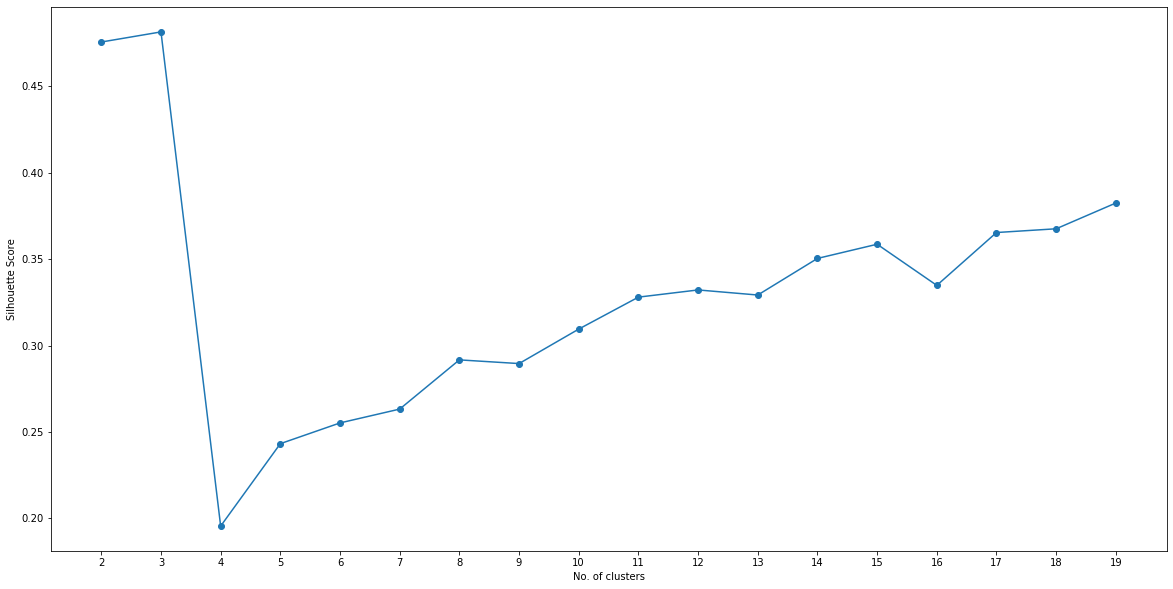

In [21]:
max_range = 20

from sklearn.metrics import silhouette_samples, silhouette_score

indices = []
scores = []

for k in range(2, max_range) :
    
    # Run k-means clustering
    bgc = belgrade_grouped_clust
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0).fit_predict(bgc)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(bgc, kmeans)
    
    # Appending the index and score to the respective lists
    indices.append(k)
    scores.append(score)

plot(max_range, scores, "No. of clusters", "Silhouette Score")

### Clustering Neighborhoods

In [22]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0).fit(belgrade_grouped_clust)

belgrade_merged = belgrade_grouped[['Neighbourhood']]
belgrade_merged = belgrade_merged.join(df.set_index('Neighbourhood'), on='Neighbourhood')
belgrade_merged['Cluster Labels'] = kmeans.labels_
belgrade_merged = belgrade_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')
belgrade_merged.head()

,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Ada Ciganlija,44.787340,20.416270,0,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
2,Ada Medjica,44.791348,20.387977,0,Italian Restaurant,Seafood Restaurant,Eastern European Restaurant
9,Banjica,44.757170,20.477090,0,Greek Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
11,Banovo Brdo,44.777280,20.414210,1,Fast Food Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
15,Bezanija,44.809364,20.376379,0,Fast Food Restaurant,Chinese Restaurant,Falafel Restaurant


In [23]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

# set color scheme for the clusters
colors = ['red', 'purple', 'green']
# add markers to the map
markers_colors = []

for lat, lng, neighb in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighb)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='white',
    fill=True,
    fill_color='white',
    fill_opacity=0.7,
    parse_html=False).add_to(map_clusters)

for lat, lon, poi, cluster in zip(belgrade_merged['Latitude'], belgrade_merged['Longitude'], belgrade_merged['Neighbourhood'], belgrade_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors[cluster],
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)

legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 100px; height: 90; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">
                              &nbsp; Cluster 0 &nbsp; <i class="fa fa-circle fa-1x" style="color:red"></i><br>
                              &nbsp; Cluster 1 &nbsp; <i class="fa fa-circle fa-1x" style="color:purple"></i><br>
                              &nbsp; Cluster 2 &nbsp; <i class="fa fa-circle fa-1x" style="color:green"></i><br>
                              &nbsp; None &nbsp &nbsp &nbsp &nbsp; <i class="fa fa-circle fa-1x" style="color:white"></i>
                </div>
                ''' 
map_clusters.get_root().html.add_child(folium.Element(legend_html))
    
map_clusters

### Examining clusters

**CLUSTER 1**

In [24]:
belgrade_merged.loc[belgrade_merged['Cluster Labels'] == 0, belgrade_merged.columns[[0] + list(range(4, belgrade_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Ada Ciganlija,Seafood Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
2,Ada Medjica,Italian Restaurant,Seafood Restaurant,Eastern European Restaurant
9,Banjica,Greek Restaurant,Vegetarian / Vegan Restaurant,Fast Food Restaurant
15,Bezanija,Fast Food Restaurant,Chinese Restaurant,Falafel Restaurant
23,Bogoslovija,Comfort Food Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
...,...,...,...,...
198,Zapadni Vracar,Seafood Restaurant,Italian Restaurant,Vegetarian / Vegan Restaurant
201,Zeleni Venac,Chinese Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
206,Zemun,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
207,Zemun Backa,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant


**CLUSTER 2**

In [25]:
belgrade_merged.loc[belgrade_merged['Cluster Labels'] == 1, belgrade_merged.columns[[0] + list(range(4, belgrade_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
11,Banovo Brdo,Fast Food Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
76,Karaburma,Fast Food Restaurant,Eastern European Restaurant,Theme Restaurant
146,Rudo,Fast Food Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant


**CLUSTER 3**

In [26]:
belgrade_merged.loc[belgrade_merged['Cluster Labels'] == 2, belgrade_merged.columns[[0] + list(range(4, belgrade_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
57,Golf Naselje,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
136,Petlovo Brdo,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
168,Sumice,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
192,Vojni Put,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
193,Vojni Put I,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
194,Vojni Put II,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
203,Zeleznicka Kolonija,Eastern European Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant
